# Biblioteki

In [37]:
import numpy as np
import pandas as pd
import json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = [15, 10]
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, Lasso

import itertools

# Deklaracje

In [3]:
def plot_ts(ts):
    fig, ax = plt.subplots()
    ts_roll_mean = ts.rolling(window=12).mean()
    ts_roll_std = ts.rolling(window=12).std()
    
    ts.plot(color='blue', label='Original', use_index=False)
    ts_roll_mean.plot(color='red', label="Rolling mean", use_index=False)
    ts_roll_std.plot(color='black', label="Rolling std", use_index=False)
    
    ax.set_xticklabels(ts.index)
    fig.autofmt_xdate()
    
    
    plt.xlabel('Date')
    plt.ylabel('Return ratio')
    plt.show()
    
def perform_dft(ts):
    #Perform Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(y_train, autolag='AIC')
    add_col = []
    values = list(dftest[0:4])
    for key,value in dftest[4].items():
        add_col.append('Critical Value (%s)'%key)
        values.append(value)

    dfoutput = pd.DataFrame(data = [values], index=['Wartość'], columns=['Test Statistic','p-value','#Lags Used','Number of Observations Used']+add_col)
    display(dfoutput)

def decompose(ts):
    decomposition = seasonal_decompose(ts, freq=10) 
    decomposition.plot()
    plt.show()
    
def find_best_hparameters(ts, x, pmax, d, qmax):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for p in range(pmax+1):
        for q in range(qmax+1):
            order = (p,d,q)
            try:
                model = SARIMAX(ts, x, order=order, freq='B', trend='c')
                results = model.fit()
                rmse_value = rmse(results.fittedvalues, ts)
                rmse_value_list.append(rmse_value)
                order_list.append(order)
            except Exception as e:
                errors_dict[str(order)] = {'error_str': str(e)}
    
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best10 = tuple(order for order, rmse_value in results[:10])
    return best10, results

# def find_best_extra_vars(ts, x_array, order, n_max=4):
#     errors_dict = {}
#     rmse_value_list = []
#     order_list = []
#     for i in range(2, n_max+1):
#         print(i)
#         try:
#             model = SARIMAX(ts, order=order, freq='B')
#             results = model.fit()
#             rmse_value = rmse(results.fittedvalues, ts)
#             rmse_value_list.append(rmse_value)
#             order_list.append(order)
#         except Exception as e:
#             errors_dict[str(order)] = {'error_str': str(e)}
    
#     errors = pd.DataFrame.from_dict(errors_dict, orient='index')
#     display(errors)
    
#     results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
#     best10 = tuple(order for order, rmse_value in results[:10])
#     return best10, results

def select_best_orders_from_best10(ts, x, best10):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in best10:
        try:
            model = SARIMAX(ts, x, order=order, freq='B', trend='c')
            results = model.fit()
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def test_orders(ts, orders):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in orders:
        try:
            model = ARIMA(ts, order=order, freq='B')
            results = model.fit()
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def show_est_plot(ts, x_array=None, order=None, zero=False, naiwny=False, label="Wykres"):
    if zero == True:
        z = [0]*len(ts)
        rmse_value = rmse(ts, z)
        plt.plot(ts.index, z, label="Zero", color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    elif naiwny == True:
        rmse_value = rmse(ts[1:], ts.shift()[1:])
        plt.plot(ts[1:].index, ts.shift()[1:], label="Naiwny", color='red')
        plt.plot(ts[1:].index, ts[1:], label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    else:
        model = SARIMAX(ts, x_array, order=order, freq='B', trend='c')
        results = model.fit()
        rmse_value = rmse(results.fittedvalues, ts)
        plt.plot(ts.index, results.fittedvalues, label=label, color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
        

# Wczytanie zbiorów

In [4]:
train = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/train_ekon.csv', index_col=0)
val1 = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/valid1_ekon.csv', index_col=0)
val2 = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/valid2_ekon.csv', index_col=0)
val3 = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/valid3_ekon.csv', index_col=0)
test = pd.read_csv('datasets/podzielone/ekonometryczne/stacjonarne/test_ekon.csv', index_col=0)

train.index = pd.to_datetime(train.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
val3.index = pd.to_datetime(val3.index)
test.index = pd.to_datetime(test.index)

whole = pd.concat([train, val1, val2, val3, test]).fillna(method='bfill')

train1 = train.asfreq('B', method='bfill').fillna(method='bfill')
train2 = pd.concat([train, val1]).asfreq('B', method='bfill').fillna(method='bfill')
train3 = pd.concat([train, val1, val2]).asfreq('B', method='bfill').fillna(method='bfill')

val1 = val1.asfreq('B', method='bfill').fillna(method='bfill')
val2 = val2.asfreq('B', method='bfill').fillna(method='bfill')
val3 = val3.asfreq('B', method='bfill').fillna(method='bfill')
test = test.asfreq('B', method='bfill').fillna(method='bfill')

val = pd.concat([val1, val2, val3]).asfreq('B', method='bfill').fillna(method='bfill')


In [6]:
train1["day_of_week"] = train1.index.dayofweek
train1["day_of_year"] = train1.index.dayofweek
train1["week"] = train1.index.week
train1["quarter"] = train1.index.quarter


val["day_of_week"] = val.index.dayofweek
val["day_of_year"] = val.index.dayofweek
val["week"] = val.index.week
val["quarter"] = val.index.quarter


# Wybór hiperparametrów

In [7]:
last_candidates = [
    ['MIN_diff_1', 'MININDEX_diff_1_shift_19'],
    ['SandP_diff_1', 'NasdaqTech_diff_1'],
    ['SandP_diff_1', 'NasdaqTech_diff_1', 'MININDEX_diff_1_shift_19', 'week'],
]

## Trening 1

In [19]:
results_of_e = []
for train_variables in last_candidates:
    X_train1 = train1[train_variables]
    y_train1 = train1['y_return_ratio']
    
    X_val1 = val1[train_variables]
    y_val1 = val1['y_return_ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val1)):
                    trainX = pd.concat([X_train1, X_val1.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train1, y_val1.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train1, X_train1, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val1.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val1)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

0.02811816343926858


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:                        SARIMAX   Log Likelihood                3453.504
Date:                Sun, 14 Apr 2019   AIC                          -6899.007
Time:                        10:30:43   BIC                          -6877.931
Sample:                    07-02-2012   HQIC                         -6891.138
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.388      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.280      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.555      0.120      -0.001    6.26e-05
sigma2                       0.0005   5.02e-06     94.618      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.97   Jarque-Bera (JB):             55228.67
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028112380867204655


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3453.509
Date:                Sun, 14 Apr 2019   AIC                          -6897.017
Time:                        10:31:05   BIC                          -6870.673
Sample:                    07-02-2012   HQIC                         -6887.181
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.395      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.275      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.542      0.123      -0.001    6.52e-05
ma.L1                       -0.0024      0.020     -0.122      0.903      -0.041       0.036
sigma2                       0.0005   5.32e-06     89.426      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.03   Jarque-Bera (JB):             55125.09
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02810332964009423


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3453.608
Date:                Sun, 14 Apr 2019   AIC                          -6895.215
Time:                        10:31:51   BIC                          -6863.602
Sample:                    07-02-2012   HQIC                         -6883.412
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.334      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.257      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.505      0.132      -0.001     7.1e-05
ma.L1                       -0.0043      0.020     -0.221      0.825      -0.043       0.034
ma.L2                        0.0128      0.026      0.493      0.622      -0.038       0.064
sigma2                       0.0005    5.5e-06     86.381      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.99   Jarque-Bera (JB):             55454.61
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02810767595526567


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3455.472
Date:                Sun, 14 Apr 2019   AIC                          -6896.943
Time:                        10:32:57   BIC                          -6860.061
Sample:                    07-02-2012   HQIC                         -6883.173
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.182      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.266      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.442      0.149      -0.001    8.12e-05
ma.L1                       -0.0054      0.020     -0.273      0.785      -0.044       0.033
ma.L2                        0.0125      0.026      0.481      0.630      -0.038       0.063
ma.L3                        0.0529      0.022      2.440      0.015       0.010       0.095
sigma2                       0.0005   5.54e-06     85.499      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.75   Jarque-Bera (JB):             56011.94
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028111464452421374


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3453.509
Date:                Sun, 14 Apr 2019   AIC                          -6897.018
Time:                        10:33:29   BIC                          -6870.673
Sample:                    07-02-2012   HQIC                         -6887.182
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.393      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.275      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.541      0.123      -0.001    6.53e-05
ar.L1                       -0.0027      0.020     -0.138      0.890      -0.041       0.036
sigma2                       0.0005   5.32e-06     89.434      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.04   Jarque-Bera (JB):             55111.64
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.028099205786496793


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3454.245
Date:                Sun, 14 Apr 2019   AIC                          -6894.491
Time:                        10:35:52   BIC                          -6857.609
Sample:                    07-02-2012   HQIC                         -6880.720
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0013      0.001      0.870      0.384      -0.002       0.004
MIN_diff_1                   0.0012      0.000      3.230      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.486      0.137      -0.001    7.43e-05
ar.L1                        0.4266      0.620      0.688      0.491      -0.789       1.642
ma.L1                       -0.4319      0.620     -0.696      0.486      -1.647       0.784
ma.L2                        0.0318      0.027      1.198      0.231      -0.020       0.084
sigma2                       0.0005   5.68e-06     83.589      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.52   Jarque-Bera (JB):             55873.84
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028097404127288228


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3455.623
Date:                Sun, 14 Apr 2019   AIC                          -6895.247
Time:                        10:37:32   BIC                          -6853.096
Sample:                    07-02-2012   HQIC                         -6879.509
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0019      0.001      1.462      0.144      -0.001       0.005
MIN_diff_1                   0.0012      0.000      3.259      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.449      0.147      -0.001       8e-05
ar.L1                        0.1406      0.525      0.268      0.789      -0.888       1.169
ma.L1                       -0.1463      0.524     -0.279      0.780      -1.173       0.880
ma.L2                        0.0091      0.026      0.350      0.726      -0.042       0.060
ma.L3                        0.0459      0.022      2.048      0.041       0.002       0.090
sigma2                       0.0005   6.21e-06     76.357      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.49   Jarque-Bera (JB):             55528.86
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028113275228706106


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3453.608
Date:                Sun, 14 Apr 2019   AIC                          -6895.216
Time:                        10:38:04   BIC                          -6863.602
Sample:                    07-02-2012   HQIC                         -6883.412
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      3.345      0.001       0.001       0.004
MIN_diff_1                   0.0012      0.000      3.256      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.529      0.126      -0.001    6.74e-05
ar.L1                       -0.0017      0.020     -0.084      0.933      -0.040       0.037
ar.L2                        0.0121      0.026      0.468      0.640      -0.039       0.063
sigma2                       0.0005   5.48e-06     86.689      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.90   Jarque-Bera (JB):             55538.46
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028095762213889236


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 3)   Log Likelihood                3455.920
Date:                Sun, 14 Apr 2019   AIC                          -6893.840
Time:                        10:39:39   BIC                          -6846.420
Sample:                    07-02-2012   HQIC                         -6876.136
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      1.725      0.084      -0.000       0.004
MIN_diff_1                   0.0012      0.000      3.245      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.410      0.159      -0.001    8.63e-05
ar.L1                        0.2173      0.503      0.432      0.666      -0.769       1.203
ar.L2                       -0.1392      0.462     -0.301      0.763      -1.044       0.766
ma.L1                       -0.2231      0.502     -0.444      0.657      -1.208       0.762
ma.L2                        0.1509      0.465      0.325      0.745      -0.760       1.062
ma.L3                        0.0539      0.026      2.108      0.035       0.004       0.104
sigma2                       0.0005   6.64e-06     71.312      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       38.23   Jarque-Bera (JB):             55348.08
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028118453491587325


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3455.289
Date:                Sun, 14 Apr 2019   AIC                          -6896.577
Time:                        10:40:16   BIC                          -6859.695
Sample:                    07-02-2012   HQIC                         -6882.807
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      3.146      0.002       0.001       0.003
MIN_diff_1                   0.0012      0.000      3.251      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.454      0.146      -0.001    7.94e-05
ar.L1                       -0.0018      0.020     -0.093      0.926      -0.041       0.037
ar.L2                        0.0118      0.026      0.456      0.649      -0.039       0.062
ar.L3                        0.0491      0.021      2.290      0.022       0.007       0.091
sigma2                       0.0005   5.45e-06     86.987      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.30   Jarque-Bera (JB):             56189.84
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028117803354250993


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 1)   Log Likelihood                3455.291
Date:                Sun, 14 Apr 2019   AIC                          -6894.583
Time:                        10:41:08   BIC                          -6852.432
Sample:                    07-02-2012   HQIC                         -6878.845
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      1.544      0.123      -0.001       0.005
MIN_diff_1                   0.0012      0.000      3.245      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.450      0.147      -0.001       8e-05
ar.L1                       -0.0004      0.546     -0.001      0.999      -1.071       1.071
ar.L2                        0.0118      0.026      0.455      0.649      -0.039       0.062
ar.L3                        0.0491      0.022      2.202      0.028       0.005       0.093
ma.L1                       -0.0015      0.546     -0.003      0.998      -1.072       1.069
sigma2                       0.0005   6.41e-06     73.953      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.30   Jarque-Bera (JB):             56186.77
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028395649521334113


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3453.418
Date:                Sun, 14 Apr 2019   AIC                          -6888.835
Time:                        10:42:50   BIC                          -6841.415
Sample:                    07-02-2012   HQIC                         -6871.130
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0025      0.001      3.298      0.001       0.001       0.004
MIN_diff_1                   0.0010      0.000      2.630      0.009       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.197      0.231      -0.000       0.000
ar.L1                        0.8049      0.039     20.859      0.000       0.729       0.880
ar.L2                       -0.9007      0.039    -23.392      0.000      -0.976      -0.825
ar.L3                       -0.0146      0.023     -0.630      0.529      -0.060       0.031
ma.L1                       -0.8335      0.031    -27.073      0.000      -0.894      -0.773
ma.L2                        0.9494      0.027     35.103      0.000       0.896       1.002
sigma2                       0.0005   6.21e-06     76.529      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       47.65   Jarque-Bera (JB):             51875.65
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             2.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02809365680222194


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 3)   Log Likelihood                3455.985
Date:                Sun, 14 Apr 2019   AIC                          -6891.971
Time:                        10:44:53   BIC                          -6839.281
Sample:                    07-02-2012   HQIC                         -6872.298
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.002      1.384      0.166      -0.001       0.005
MIN_diff_1                   0.0012      0.000      3.253      0.001       0.000       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.407      0.159      -0.001    8.67e-05
ar.L1                        0.1763      0.556      0.317      0.751      -0.914       1.266
ar.L2                       -0.0729      0.561     -0.130      0.897      -1.173       1.027
ar.L3                       -0.0836      0.541     -0.155      0.877      -1.144       0.976
ma.L1                       -0.1810      0.553     -0.327      0.743      -1.265       0.903
ma.L2                        0.0860      0.561      0.153      0.878      -1.013       1.185
ma.L3                        0.1376      0.546      0.252      0.801      -0.932       1.207
sigma2                       0.0005   6.61e-06     71.705      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       38.07   Jarque-Bera (JB):             55455.97
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028042378905382442


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:                        SARIMAX   Log Likelihood                3451.738
Date:                Sun, 14 Apr 2019   AIC                          -6895.476
Time:                        10:45:46   BIC                          -6874.401
Sample:                    07-02-2012   HQIC                         -6887.607
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.306      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.69e-05     -1.647      0.100      -0.000    2.09e-05
NasdaqTech_diff_1  7.039e-05   3.91e-05      1.800      0.072   -6.25e-06       0.000
sigma2                0.0005   5.54e-06     86.057      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       47.95   Jarque-Bera (JB):             55776.69
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02807606449788056


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3451.953
Date:                Sun, 14 Apr 2019   AIC                          -6893.905
Time:                        10:46:35   BIC                          -6867.561
Sample:                    07-02-2012   HQIC                         -6884.069
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.454      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.66e-05     -1.591      0.112      -0.000    2.46e-05
NasdaqTech_diff_1  8.046e-05   4.15e-05      1.941      0.052   -7.86e-07       0.000
ma.L1                -0.0189      0.021     -0.888      0.375      -0.061       0.023
sigma2                0.0005   5.98e-06     79.672      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.14   Jarque-Bera (JB):             54819.61
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.02805696141076723


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3451.981
Date:                Sun, 14 Apr 2019   AIC                          -6891.962
Time:                        10:48:10   BIC                          -6860.349
Sample:                    07-02-2012   HQIC                         -6880.159
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.473      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.69e-05     -1.597      0.110      -0.000    2.43e-05
NasdaqTech_diff_1  7.923e-05    4.2e-05      1.885      0.059   -3.16e-06       0.000
ma.L1                -0.0211      0.021     -0.983      0.326      -0.063       0.021
ma.L2                 0.0064      0.027      0.235      0.814      -0.047       0.059
sigma2                0.0005   6.36e-06     74.891      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.24   Jarque-Bera (JB):             54963.36
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028022667161270744


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3454.103
Date:                Sun, 14 Apr 2019   AIC                          -6894.205
Time:                        10:49:47   BIC                          -6857.323
Sample:                    07-02-2012   HQIC                         -6880.435
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.233      0.001       0.001       0.003
SandP_diff_1         -0.0001    6.7e-05     -1.801      0.072      -0.000    1.06e-05
NasdaqTech_diff_1  8.228e-05   4.16e-05      1.979      0.048       8e-07       0.000
ma.L1                -0.0223      0.022     -1.035      0.301      -0.065       0.020
ma.L2                 0.0032      0.027      0.120      0.904      -0.050       0.056
ma.L3                 0.0506      0.022      2.328      0.020       0.008       0.093
sigma2                0.0005   6.29e-06     75.532      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       42.85   Jarque-Bera (JB):             55623.01
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.02808006944358194


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3451.958
Date:                Sun, 14 Apr 2019   AIC                          -6893.916
Time:                        10:50:34   BIC                          -6867.572
Sample:                    07-02-2012   HQIC                         -6884.080
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.392      0.001       0.001       0.004
SandP_diff_1         -0.0001   6.65e-05     -1.591      0.112      -0.000    2.45e-05
NasdaqTech_diff_1  8.069e-05   4.13e-05      1.952      0.051   -3.18e-07       0.000
ar.L1                -0.0197      0.021     -0.925      0.355      -0.061       0.022
sigma2                0.0005   5.95e-06     80.062      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.16   Jarque-Bera (JB):             54794.44
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02804054031508746


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3452.085
Date:                Sun, 14 Apr 2019   AIC                          -6890.171
Time:                        10:52:14   BIC                          -6853.288
Sample:                    07-02-2012   HQIC                         -6876.400
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0014      0.012      0.122      0.903      -0.021       0.024
SandP_diff_1         -0.0001   6.77e-05     -1.800      0.072      -0.000    1.08e-05
NasdaqTech_diff_1   8.53e-05   4.24e-05      2.012      0.044    2.23e-06       0.000
ar.L1                 0.3412      5.394      0.063      0.950     -10.231      10.913
ma.L1                -0.3620      5.396     -0.067      0.947     -10.937      10.213
ma.L2                 0.0106      0.103      0.103      0.918      -0.190       0.212
sigma2                0.0005    6.5e-06     73.392      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.12   Jarque-Bera (JB):             55079.00
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028003420323307455


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3454.124
Date:                Sun, 14 Apr 2019   AIC                          -6892.249
Time:                        10:52:42   BIC                          -6850.097
Sample:                    07-02-2012   HQIC                         -6876.511
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      1.521      0.128      -0.001       0.005
SandP_diff_1         -0.0001    6.9e-05     -1.582      0.114      -0.000     2.6e-05
NasdaqTech_diff_1  7.627e-05   4.19e-05      1.819      0.069   -5.93e-06       0.000
ar.L1                 0.1023      0.528      0.194      0.846      -0.933       1.138
ma.L1                -0.1246      0.528     -0.236      0.813      -1.160       0.911
ma.L2                 0.0045      0.029      0.156      0.876      -0.053       0.062
ma.L3                 0.0491      0.022      2.224      0.026       0.006       0.092
sigma2                0.0005   6.83e-06     69.660      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       42.42   Jarque-Bera (JB):             55219.87
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               2.90   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028071524869025435


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3451.975
Date:                Sun, 14 Apr 2019   AIC                          -6891.951
Time:                        10:53:39   BIC                          -6860.337
Sample:                    07-02-2012   HQIC                         -6880.148
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.340      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.69e-05     -1.594      0.111      -0.000    2.45e-05
NasdaqTech_diff_1  7.934e-05    4.2e-05      1.891      0.059   -2.91e-06       0.000
ar.L1                -0.0186      0.021     -0.872      0.383      -0.060       0.023
ar.L2                 0.0039      0.027      0.146      0.884      -0.049       0.057
sigma2                0.0005   6.34e-06     75.128      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.17   Jarque-Bera (JB):             54990.50
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.028033992088388554


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(2, 0, 3)   Log Likelihood                3454.781
Date:                Sun, 14 Apr 2019   AIC                          -6891.562
Time:                        10:55:37   BIC                          -6844.142
Sample:                    07-02-2012   HQIC                         -6873.857
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      1.659      0.097      -0.000       0.005
SandP_diff_1         -0.0001   6.82e-05     -1.812      0.070      -0.000    1.01e-05
NasdaqTech_diff_1   8.55e-05   4.16e-05      2.053      0.040    3.88e-06       0.000
ar.L1                 0.2204      0.517      0.426      0.670      -0.793       1.234
ar.L2                -0.2504      0.490     -0.511      0.609      -1.210       0.710
ma.L1                -0.2430      0.517     -0.470      0.639      -1.257       0.771
ma.L2                 0.2563      0.500      0.513      0.608      -0.723       1.236
ma.L3                 0.0441      0.028      1.553      0.120      -0.012       0.100
sigma2                0.0005   7.07e-06     67.175      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.79   Jarque-Bera (JB):             54986.23
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028020956074116428


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3453.857
Date:                Sun, 14 Apr 2019   AIC                          -6893.715
Time:                        10:56:56   BIC                          -6856.832
Sample:                    07-02-2012   HQIC                         -6879.944
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0021      0.001      3.151      0.002       0.001       0.003
SandP_diff_1         -0.0001   6.69e-05     -1.802      0.072      -0.000    1.06e-05
NasdaqTech_diff_1  7.983e-05   4.14e-05      1.930      0.054   -1.25e-06       0.000
ar.L1                -0.0184      0.021     -0.857      0.391      -0.060       0.024
ar.L2                 0.0044      0.027      0.165      0.869      -0.048       0.057
ar.L3                 0.0509      0.022      2.347      0.019       0.008       0.093
sigma2                0.0005   6.21e-06     76.579      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.41   Jarque-Bera (JB):             55991.89
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028033355786209996


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 1)   Log Likelihood                3453.857
Date:                Sun, 14 Apr 2019   AIC                          -6891.715
Time:                        10:58:07   BIC                          -6849.563
Sample:                    07-02-2012   HQIC                         -6875.977
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0021      0.001      1.499      0.134      -0.001       0.005
SandP_diff_1         -0.0001   6.94e-05     -1.575      0.115      -0.000    2.67e-05
NasdaqTech_diff_1  7.468e-05   4.19e-05      1.784      0.074   -7.38e-06       0.000
ar.L1                -0.0089      0.551     -0.016      0.987      -1.089       1.071
ar.L2                 0.0045      0.028      0.160      0.873      -0.051       0.060
ar.L3                 0.0508      0.022      2.332      0.020       0.008       0.093
ma.L1                -0.0095      0.551     -0.017      0.986      -1.090       1.071
sigma2                0.0005   6.92e-06     68.663      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.26   Jarque-Bera (JB):             55842.02
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028378858172882906


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3451.630
Date:                Sun, 14 Apr 2019   AIC                          -6885.260
Time:                        11:00:00   BIC                          -6837.840
Sample:                    07-02-2012   HQIC                         -6867.555
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0024      0.001      3.238      0.001       0.001       0.004
SandP_diff_1         -0.0001   6.97e-05     -2.111      0.035      -0.000   -1.05e-05
NasdaqTech_diff_1  6.979e-05   4.18e-05      1.671      0.095   -1.21e-05       0.000
ar.L1                 0.7944      0.041     19.524      0.000       0.715       0.874
ar.L2                -0.9240      0.037    -24.990      0.000      -0.997      -0.852
ar.L3                 0.0305      0.023      1.307      0.191      -0.015       0.076
ma.L1                -0.7890      0.032    -24.286      0.000      -0.853      -0.725
ma.L2                 0.9400      0.028     34.086      0.000       0.886       0.994
sigma2                0.0005   6.36e-06     74.772      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       47.37   Jarque-Bera (JB):             54040.60
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             2.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028032705942820344


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 3)   Log Likelihood                3454.781
Date:                Sun, 14 Apr 2019   AIC                          -6889.562
Time:                        11:01:48   BIC                          -6836.872
Sample:                    07-02-2012   HQIC                         -6869.889
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.002      0.908      0.364      -0.003       0.007
SandP_diff_1         -0.0001      7e-05     -1.766      0.077      -0.000    1.35e-05
NasdaqTech_diff_1  8.537e-05    4.2e-05      2.030      0.042    2.96e-06       0.000
ar.L1                 0.2254      0.810      0.278      0.781      -1.361       1.812
ar.L2                -0.2559      0.611     -0.419      0.675      -1.453       0.942
ar.L3                 0.0077      0.690      0.011      0.991      -1.344       1.360
ma.L1                -0.2480      0.808     -0.307      0.759      -1.832       1.336
ma.L2                 0.2619      0.627      0.418      0.676      -0.967       1.491
ma.L3                 0.0363      0.702      0.052      0.959      -1.340       1.412
sigma2                0.0005   7.06e-06     67.194      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.79   Jarque-Bera (JB):             54987.59
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

KeyError: "['week'] not in index"

In [20]:
sorted(results_of_e, key=lambda x: x[2])

[((1, 0, 3), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.028003420323307455),
 ((3, 0, 0), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.028020956074116428),
 ((0, 0, 3), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.028022667161270744),
 ((3, 0, 3), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.028032705942820344),
 ((3, 0, 1), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.028033355786209996),
 ((2, 0, 3), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.028033992088388554),
 ((1, 0, 2), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.02804054031508746),
 ((0, 0, 0), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.028042378905382442),
 ((0, 0, 2), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.02805696141076723),
 ((2, 0, 0), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.028071524869025435),
 ((0, 0, 1), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.02807606449788056),
 ((1, 0, 0), ['SandP_diff_1', 'NasdaqTech_diff_1'], 0.02808006944358194),
 ((3, 0, 3), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.02809365680222194),
 ((2, 0, 3), ['MIN_diff_1

## Trening 2

In [26]:
results_of_e = []
for train_variables in last_candidates:
    X_train2 = train2[train_variables]
    y_train2 = train2['y_return_ratio']
    
    X_val2 = val2[train_variables]
    y_val2 = val2['y_return_ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val2)):
                    trainX = pd.concat([X_train2, X_val2.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train2, y_val2.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train2, X_train2, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val2.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val2)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

0.028200700923861736


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:                        SARIMAX   Log Likelihood                3543.079
Date:                Sun, 14 Apr 2019   AIC                          -7078.158
Time:                        11:38:44   BIC                          -7056.964
Sample:                    07-02-2012   HQIC                         -7070.257
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.453      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.453      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.148      0.251      -0.000       0.000
sigma2                       0.0005   5.14e-06     94.277      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.24   Jarque-Bera (JB):             50243.96
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028224038976746517


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3543.121
Date:                Sun, 14 Apr 2019   AIC                          -7076.241
Time:                        11:39:16   BIC                          -7049.749
Sample:                    07-02-2012   HQIC                         -7066.364
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.471      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.458      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.132      0.258      -0.000       0.000
ma.L1                       -0.0074      0.019     -0.384      0.701      -0.045       0.031
sigma2                       0.0005    5.4e-06     89.696      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.38   Jarque-Bera (JB):             49957.74
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028223083770987586


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3543.216
Date:                Sun, 14 Apr 2019   AIC                          -7074.431
Time:                        11:39:59   BIC                          -7042.640
Sample:                    07-02-2012   HQIC                         -7062.579
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.404      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.429      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.107      0.268      -0.000       0.000
ma.L1                       -0.0093      0.020     -0.476      0.634      -0.048       0.029
ma.L2                        0.0121      0.026      0.475      0.635      -0.038       0.062
sigma2                       0.0005   5.55e-06     87.297      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.32   Jarque-Bera (JB):             50225.49
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02827352661613341


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3545.965
Date:                Sun, 14 Apr 2019   AIC                          -7077.930
Time:                        11:40:46   BIC                          -7040.841
Sample:                    07-02-2012   HQIC                         -7064.103
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.219      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.429      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0001      0.000     -1.012      0.312      -0.000       0.000
ma.L1                       -0.0101      0.020     -0.511      0.609      -0.049       0.029
ma.L2                        0.0123      0.025      0.484      0.629      -0.038       0.062
ma.L3                        0.0633      0.022      2.905      0.004       0.021       0.106
sigma2                       0.0005   5.59e-06     86.314      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       41.00   Jarque-Bera (JB):             50948.32
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02822464670266067


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3543.121
Date:                Sun, 14 Apr 2019   AIC                          -7076.243
Time:                        11:41:12   BIC                          -7049.751
Sample:                    07-02-2012   HQIC                         -7066.366
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.478      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.458      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.132      0.258      -0.000       0.000
ar.L1                       -0.0076      0.019     -0.393      0.694      -0.046       0.030
sigma2                       0.0005    5.4e-06     89.764      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.38   Jarque-Bera (JB):             49952.22
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02822792386332116


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3543.893
Date:                Sun, 14 Apr 2019   AIC                          -7073.785
Time:                        11:42:29   BIC                          -7036.696
Sample:                    07-02-2012   HQIC                         -7059.958
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0014      0.001      0.978      0.328      -0.001       0.004
MIN_diff_1                   0.0013      0.000      3.410      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.082      0.279      -0.000       0.000
ar.L1                        0.3725      0.600      0.621      0.535      -0.804       1.549
ma.L1                       -0.3831      0.600     -0.638      0.523      -1.560       0.793
ma.L2                        0.0345      0.025      1.364      0.173      -0.015       0.084
sigma2                       0.0005   5.75e-06     84.198      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       46.86   Jarque-Bera (JB):             50669.21
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02828190716701419


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3546.050
Date:                Sun, 14 Apr 2019   AIC                          -7076.101
Time:                        11:42:59   BIC                          -7033.713
Sample:                    07-02-2012   HQIC                         -7060.298
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0020      0.001      1.814      0.070      -0.000       0.004
MIN_diff_1                   0.0013      0.000      3.429      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0001      0.000     -1.022      0.307      -0.000       0.000
ar.L1                        0.0986      0.423      0.233      0.815      -0.730       0.927
ma.L1                       -0.1092      0.422     -0.259      0.796      -0.937       0.718
ma.L2                        0.0087      0.026      0.340      0.734      -0.042       0.059
ma.L3                        0.0565      0.022      2.564      0.010       0.013       0.100
sigma2                       0.0005   6.28e-06     76.765      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.95   Jarque-Bera (JB):             50534.13
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02821556208746963


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3543.205
Date:                Sun, 14 Apr 2019   AIC                          -7074.409
Time:                        11:43:35   BIC                          -7042.619
Sample:                    07-02-2012   HQIC                         -7062.558
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.439      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.443      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.122      0.262      -0.000       0.000
ar.L1                       -0.0066      0.019     -0.339      0.735      -0.045       0.031
ar.L2                        0.0108      0.025      0.427      0.670      -0.039       0.061
sigma2                       0.0005   5.53e-06     87.560      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       48.25   Jarque-Bera (JB):             50290.86
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028219852150121738


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(2, 0, 2)   Log Likelihood                3544.239
Date:                Sun, 14 Apr 2019   AIC                          -7072.479
Time:                        11:44:44   BIC                          -7030.091
Sample:                    07-02-2012   HQIC                         -7056.676
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      2.382      0.017       0.000       0.004
MIN_diff_1                   0.0013      0.000      3.292      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0001      0.000     -1.037      0.300      -0.000       0.000
ar.L1                        0.8557      0.280      3.057      0.002       0.307       1.404
ar.L2                       -0.8397      0.295     -2.844      0.004      -1.418      -0.261
ma.L1                       -0.8597      0.272     -3.162      0.002      -1.393      -0.327
ma.L2                        0.8524      0.284      2.999      0.003       0.295       1.410
sigma2                       0.0005   6.22e-06     77.738      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.25   Jarque-Bera (JB):             50223.72
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               3.10   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028294506934584015


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(2, 0, 3)   Log Likelihood                3546.194
Date:                Sun, 14 Apr 2019   AIC                          -7074.387
Time:                        11:47:06   BIC                          -7026.701
Sample:                    07-02-2012   HQIC                         -7056.609
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      1.754      0.079      -0.000       0.004
MIN_diff_1                   0.0013      0.000      3.401      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0001      0.000     -0.991      0.322      -0.000       0.000
ar.L1                        0.1263      0.456      0.277      0.782      -0.768       1.021
ar.L2                       -0.0553      0.426     -0.130      0.897      -0.891       0.781
ma.L1                       -0.1360      0.456     -0.298      0.766      -1.030       0.758
ma.L2                        0.0678      0.429      0.158      0.874      -0.773       0.908
ma.L3                        0.0587      0.024      2.401      0.016       0.011       0.107
sigma2                       0.0005    6.6e-06     73.101      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       40.42   Jarque-Bera (JB):             50605.10
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.028237541939040336


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3545.669
Date:                Sun, 14 Apr 2019   AIC                          -7077.338
Time:                        11:48:23   BIC                          -7040.249
Sample:                    07-02-2012   HQIC                         -7063.511
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      3.204      0.001       0.001       0.003
MIN_diff_1                   0.0013      0.000      3.420      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0001      0.000     -1.025      0.305      -0.000       0.000
ar.L1                       -0.0068      0.020     -0.348      0.728      -0.045       0.032
ar.L2                        0.0108      0.025      0.428      0.669      -0.039       0.060
ar.L3                        0.0583      0.022      2.709      0.007       0.016       0.100
sigma2                       0.0005   5.49e-06     87.952      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       41.89   Jarque-Bera (JB):             51119.55
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02823808021638595


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(3, 0, 1)   Log Likelihood                3545.676
Date:                Sun, 14 Apr 2019   AIC                          -7075.353
Time:                        11:49:11   BIC                          -7032.965
Sample:                    07-02-2012   HQIC                         -7059.550
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      1.818      0.069      -0.000       0.004
MIN_diff_1                   0.0013      0.000      3.414      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0001      0.000     -1.025      0.305      -0.000       0.000
ar.L1                       -0.0028      0.441     -0.006      0.995      -0.866       0.861
ar.L2                        0.0108      0.025      0.426      0.670      -0.039       0.060
ar.L3                        0.0582      0.022      2.661      0.008       0.015       0.101
ma.L1                       -0.0040      0.441     -0.009      0.993      -0.868       0.860
sigma2                       0.0005   6.42e-06     75.225      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       41.87   Jarque-Bera (JB):             51107.71
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.0283767848626938


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3546.186
Date:                Sun, 14 Apr 2019   AIC                          -7074.371
Time:                        11:50:58   BIC                          -7026.685
Sample:                    07-02-2012   HQIC                         -7056.593
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0024      0.001      2.869      0.004       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.267      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0001      0.000     -0.900      0.368      -0.000       0.000
ar.L1                        0.6268      0.179      3.497      0.000       0.276       0.978
ar.L2                       -0.7205      0.166     -4.342      0.000      -1.046      -0.395
ar.L3                        0.0456      0.026      1.742      0.081      -0.006       0.097
ma.L1                       -0.6261      0.179     -3.503      0.000      -0.976      -0.276
ma.L2                        0.7340      0.166      4.417      0.000       0.408       1.060
sigma2                       0.0005   6.55e-06     73.669      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       38.86   Jarque-Bera (JB):             49139.70
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               3.05   Skew:                             2.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028343808580323312


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(3, 0, 3)   Log Likelihood                3546.573
Date:                Sun, 14 Apr 2019   AIC                          -7073.146
Time:                        11:52:14   BIC                          -7020.161
Sample:                    07-02-2012   HQIC                         -7053.392
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0024      0.001      1.710      0.087      -0.000       0.005
MIN_diff_1                   0.0013      0.000      3.449      0.001       0.001       0.002
MININDEX_diff_1_shift_19    -0.0001      0.000     -0.966      0.334      -0.000       0.000
ar.L1                        0.0413      0.380      0.109      0.914      -0.704       0.786
ar.L2                        0.0696      0.394      0.177      0.860      -0.702       0.841
ar.L3                       -0.1896      0.410     -0.463      0.644      -0.993       0.613
ma.L1                       -0.0523      0.376     -0.139      0.889      -0.790       0.685
ma.L2                       -0.0565      0.390     -0.145      0.885      -0.820       0.707
ma.L3                        0.2556      0.409      0.625      0.532      -0.546       1.058
sigma2                       0.0005   6.55e-06     73.646      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.25   Jarque-Bera (JB):             50411.39
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02881491566542334


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:                        SARIMAX   Log Likelihood                3541.437
Date:                Sun, 14 Apr 2019   AIC                          -7074.874
Time:                        11:52:38   BIC                          -7053.680
Sample:                    07-02-2012   HQIC                         -7066.973
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      3.579      0.000       0.001       0.004
SandP_diff_1         -0.0001   6.49e-05     -2.143      0.032      -0.000   -1.19e-05
NasdaqTech_diff_1  6.835e-05   3.75e-05      1.825      0.068   -5.07e-06       0.000
sigma2                0.0005   5.55e-06     87.520      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       52.20   Jarque-Bera (JB):             51069.46
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.02910012214582068


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3541.647
Date:                Sun, 14 Apr 2019   AIC                          -7073.293
Time:                        11:53:32   BIC                          -7046.801
Sample:                    07-02-2012   HQIC                         -7063.417
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0024      0.001      3.739      0.000       0.001       0.004
SandP_diff_1         -0.0001   6.48e-05     -2.080      0.038      -0.000   -7.79e-06
NasdaqTech_diff_1  7.871e-05   3.99e-05      1.971      0.049    4.32e-07       0.000
ma.L1                -0.0193      0.022     -0.898      0.369      -0.062       0.023
sigma2                0.0005   6.01e-06     80.735      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       52.41   Jarque-Bera (JB):             50174.52
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               3.08   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028993341054184475


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3541.713
Date:                Sun, 14 Apr 2019   AIC                          -7071.425
Time:                        11:54:06   BIC                          -7039.634
Sample:                    07-02-2012   HQIC                         -7059.573
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0024      0.001      3.731      0.000       0.001       0.004
SandP_diff_1         -0.0001   6.49e-05     -2.114      0.034      -0.000      -1e-05
NasdaqTech_diff_1  7.356e-05   4.03e-05      1.825      0.068   -5.44e-06       0.000
ma.L1                -0.0213      0.022     -0.985      0.325      -0.064       0.021
ma.L2                 0.0097      0.027      0.361      0.718      -0.043       0.062
sigma2                0.0005   6.34e-06     76.528      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       52.51   Jarque-Bera (JB):             50493.35
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.029037816087813036


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3544.749
Date:                Sun, 14 Apr 2019   AIC                          -7075.497
Time:                        11:55:29   BIC                          -7038.408
Sample:                    07-02-2012   HQIC                         -7061.670
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      3.409      0.001       0.001       0.004
SandP_diff_1         -0.0001   6.46e-05     -2.124      0.034      -0.000   -1.06e-05
NasdaqTech_diff_1  7.457e-05   3.98e-05      1.872      0.061   -3.52e-06       0.000
ma.L1                -0.0224      0.022     -1.029      0.304      -0.065       0.020
ma.L2                 0.0064      0.027      0.239      0.811      -0.046       0.059
ma.L3                 0.0605      0.022      2.776      0.006       0.018       0.103
sigma2                0.0005   6.31e-06     76.757      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.91   Jarque-Bera (JB):             51050.69
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02909681244547863


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3541.655
Date:                Sun, 14 Apr 2019   AIC                          -7073.310
Time:                        11:56:07   BIC                          -7046.817
Sample:                    07-02-2012   HQIC                         -7063.433
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0024      0.001      3.666      0.000       0.001       0.004
SandP_diff_1         -0.0001   6.47e-05     -2.082      0.037      -0.000   -7.87e-06
NasdaqTech_diff_1  7.881e-05   3.98e-05      1.979      0.048    7.56e-07       0.000
ar.L1                -0.0197      0.021     -0.916      0.360      -0.062       0.022
sigma2                0.0005   5.98e-06     81.118      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       52.42   Jarque-Bera (JB):             50170.11
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.0290800465276705


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3541.935
Date:                Sun, 14 Apr 2019   AIC                          -7069.871
Time:                        11:57:00   BIC                          -7032.781
Sample:                    07-02-2012   HQIC                         -7056.043
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0016      0.006      0.249      0.803      -0.011       0.014
SandP_diff_1         -0.0001   6.54e-05     -2.190      0.029      -0.000   -1.51e-05
NasdaqTech_diff_1  8.163e-05   4.05e-05      2.015      0.044    2.24e-06       0.000
ar.L1                 0.3204      2.706      0.118      0.906      -4.984       5.625
ma.L1                -0.3413      2.708     -0.126      0.900      -5.649       4.966
ma.L2                 0.0136      0.052      0.260      0.795      -0.089       0.116
sigma2                0.0005   6.46e-06     75.188      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       52.07   Jarque-Bera (JB):             50425.07
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.029073314709078986


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3544.812
Date:                Sun, 14 Apr 2019   AIC                          -7073.624
Time:                        11:57:58   BIC                          -7031.236
Sample:                    07-02-2012   HQIC                         -7057.821
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      1.862      0.063      -0.000       0.005
SandP_diff_1         -0.0001   6.65e-05     -2.066      0.039      -0.000   -7.03e-06
NasdaqTech_diff_1  7.438e-05      4e-05      1.861      0.063   -3.96e-06       0.000
ar.L1                 0.0741      0.427      0.174      0.862      -0.762       0.910
ma.L1                -0.0965      0.426     -0.226      0.821      -0.931       0.738
ma.L2                 0.0073      0.029      0.255      0.799      -0.049       0.063
ma.L3                 0.0591      0.022      2.674      0.008       0.016       0.102
sigma2                0.0005   6.76e-06     71.707      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       44.71   Jarque-Bera (JB):             50827.81
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02896515503799195


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3541.691
Date:                Sun, 14 Apr 2019   AIC                          -7071.383
Time:                        11:58:42   BIC                          -7039.592
Sample:                    07-02-2012   HQIC                         -7059.531
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      3.598      0.000       0.001       0.004
SandP_diff_1         -0.0001    6.5e-05     -2.142      0.032      -0.000   -1.18e-05
NasdaqTech_diff_1  7.377e-05   4.03e-05      1.832      0.067   -5.16e-06       0.000
ar.L1                -0.0186      0.022     -0.863      0.388      -0.061       0.024
ar.L2                 0.0068      0.027      0.257      0.797      -0.045       0.059
sigma2                0.0005   6.32e-06     76.810      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       52.45   Jarque-Bera (JB):             50548.34
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.029284142491857165


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(2, 0, 2)   Log Likelihood                3541.242
Date:                Sun, 14 Apr 2019   AIC                          -7066.485
Time:                        11:59:39   BIC                          -7024.097
Sample:                    07-02-2012   HQIC                         -7050.682
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0024      0.001      3.315      0.001       0.001       0.004
SandP_diff_1         -0.0001   6.48e-05     -2.076      0.038      -0.000   -7.55e-06
NasdaqTech_diff_1  7.817e-05   3.84e-05      2.034      0.042    2.84e-06       0.000
ar.L1                 0.8348      0.029     28.437      0.000       0.777       0.892
ar.L2                -0.9507      0.031    -30.767      0.000      -1.011      -0.890
ma.L1                -0.8566      0.022    -38.652      0.000      -0.900      -0.813
ma.L2                 0.9694      0.023     41.510      0.000       0.924       1.015
sigma2                0.0005   6.56e-06     73.667      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       50.89   Jarque-Bera (JB):             48109.73
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               3.08   Skew:                             2.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02915815752865303


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(2, 0, 3)   Log Likelihood                3545.291
Date:                Sun, 14 Apr 2019   AIC                          -7072.583
Time:                        12:00:17   BIC                          -7024.897
Sample:                    07-02-2012   HQIC                         -7054.805
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      1.833      0.067      -0.000       0.005
SandP_diff_1         -0.0001    6.6e-05     -2.058      0.040      -0.000   -6.49e-06
NasdaqTech_diff_1  7.817e-05   3.98e-05      1.962      0.050    7.76e-08       0.000
ar.L1                 0.1618      0.450      0.360      0.719      -0.720       1.043
ar.L2                -0.1837      0.413     -0.444      0.657      -0.994       0.627
ma.L1                -0.1845      0.449     -0.411      0.681      -1.065       0.696
ma.L2                 0.1919      0.421      0.456      0.648      -0.632       1.016
ma.L3                 0.0551      0.027      2.043      0.041       0.002       0.108
sigma2                0.0005   7.04e-06     68.780      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.27   Jarque-Bera (JB):             50502.19
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             2.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.02895689739742966


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3544.408
Date:                Sun, 14 Apr 2019   AIC                          -7074.817
Time:                        12:00:55   BIC                          -7037.728
Sample:                    07-02-2012   HQIC                         -7060.990
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.361      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.44e-05     -2.144      0.032      -0.000   -1.18e-05
NasdaqTech_diff_1  7.252e-05   3.96e-05      1.830      0.067   -5.17e-06       0.000
ar.L1                -0.0186      0.022     -0.860      0.390      -0.061       0.024
ar.L2                 0.0076      0.027      0.285      0.776      -0.045       0.060
ar.L3                 0.0605      0.022      2.787      0.005       0.018       0.103
sigma2                0.0005   6.18e-06     78.224      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.75   Jarque-Bera (JB):             51421.99
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.028966561535297402


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(3, 0, 1)   Log Likelihood                3544.431
Date:                Sun, 14 Apr 2019   AIC                          -7072.861
Time:                        12:01:47   BIC                          -7030.474
Sample:                    07-02-2012   HQIC                         -7057.059
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      1.797      0.072      -0.000       0.005
SandP_diff_1         -0.0001   6.66e-05     -2.071      0.038      -0.000   -7.43e-06
NasdaqTech_diff_1  7.273e-05      4e-05      1.820      0.069   -5.61e-06       0.000
ar.L1                -0.0088      0.441     -0.020      0.984      -0.872       0.855
ar.L2                 0.0076      0.028      0.275      0.783      -0.047       0.062
ar.L3                 0.0603      0.022      2.760      0.006       0.017       0.103
ma.L1                -0.0098      0.441     -0.022      0.982      -0.874       0.854
sigma2                0.0005   6.82e-06     70.918      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       45.70   Jarque-Bera (JB):             51388.62
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.029127568128957122


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3544.323
Date:                Sun, 14 Apr 2019   AIC                          -7070.646
Time:                        12:02:53   BIC                          -7022.960
Sample:                    07-02-2012   HQIC                         -7052.868
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0026      0.001      3.276      0.001       0.001       0.004
SandP_diff_1         -0.0002    6.6e-05     -2.507      0.012      -0.000   -3.61e-05
NasdaqTech_diff_1  8.686e-05   4.02e-05      2.160      0.031    8.03e-06       0.000
ar.L1                 0.6337      0.096      6.576      0.000       0.445       0.823
ar.L2                -0.7877      0.092     -8.570      0.000      -0.968      -0.608
ar.L3                 0.0427      0.026      1.624      0.104      -0.009       0.094
ma.L1                -0.6549      0.094     -6.985      0.000      -0.839      -0.471
ma.L2                 0.8046      0.093      8.669      0.000       0.623       0.987
sigma2                0.0005   6.94e-06     69.819      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       42.87   Jarque-Bera (JB):             47336.71
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               3.00   Skew:                             2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.029147979450030052


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1478
Model:               SARIMAX(3, 0, 3)   Log Likelihood                3545.338
Date:                Sun, 14 Apr 2019   AIC                          -7070.676
Time:                        12:05:41   BIC                          -7017.691
Sample:                    07-02-2012   HQIC                         -7050.923
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0024      0.002      1.265      0.206      -0.001       0.006
SandP_diff_1         -0.0002   6.72e-05     -2.316      0.021      -0.000   -2.39e-05
NasdaqTech_diff_1  8.497e-05   4.01e-05      2.117      0.034    6.31e-06       0.000
ar.L1                 0.1242      0.562      0.221      0.825      -0.978       1.226
ar.L2                -0.1396      0.470     -0.297      0.766      -1.061       0.782
ar.L3                -0.0630      0.515     -0.122      0.903      -1.073       0.947
ma.L1                -0.1468      0.560     -0.262      0.793      -1.244       0.950
ma.L2                 0.1473      0.477      0.308      0.758      -0.788       1.083
ma.L3                 0.1194      0.523      0.228      0.819      -0.905       1.144
sigma2                0.0005      7e-06     68.892      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       43.32   Jarque-Bera (JB):             50711.21
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             2.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

KeyError: "['week'] not in index"

In [27]:
results_of_e

[((0, 0, 0), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.028200700923861736),
 ((0, 0, 1), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.028224038976746517),
 ((0, 0, 2), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.028223083770987586),
 ((0, 0, 3), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.02827352661613341),
 ((1, 0, 0), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.02822464670266067),
 ((1, 0, 2), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.02822792386332116),
 ((1, 0, 3), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.02828190716701419),
 ((2, 0, 0), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.02821556208746963),
 ((2, 0, 2), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.028219852150121738),
 ((2, 0, 3), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.028294506934584015),
 ((3, 0, 0), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.028237541939040336),
 ((3, 0, 1), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.02823808021638595),
 ((3, 0, 2), ['MIN_diff_1', 'MININDEX_diff_1_s

## Trening 3

In [28]:
results_of_e = []
for train_variables in last_candidates:
    X_train3 = train3[train_variables]
    y_train3 = train3['y_return_ratio']
    
    X_val3 = val3[train_variables]
    y_val3 = val3['y_return_ratio']
    for p in range(4):
        for q in range(4):
            order = (p, 0, q)
            try:
                prediction = []
                for i in range(len(y_val3)):
                    trainX = pd.concat([X_train3, X_val3.iloc[:i]]).asfreq('B', method='bfill')[train_variables]
                    trainY = pd.concat([y_train3, y_val3.iloc[:i]]).asfreq('B', method='bfill')
                    model = SARIMAX(y_train3, X_train3, order=order, trend='c', freq='B')
                    results = model.fit()
                    y_hat = results.forecast(steps=1, exog=X_val3.iloc[i:i+1])
                    prediction.append(y_hat[0])
                rmse_value = rmse(prediction, y_val3)
                print(rmse_value)
                display(results.summary())
                results_of_e.append(((p,0,q), train_variables, rmse_value))
            except ValueError as e: pass

0.018458437674174995


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:                        SARIMAX   Log Likelihood                3632.620
Date:                Sun, 14 Apr 2019   AIC                          -7257.240
Time:                        12:13:52   BIC                          -7235.932
Sample:                    07-02-2012   HQIC                         -7249.308
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      3.408      0.001       0.001       0.004
MIN_diff_1                   0.0014      0.000      3.684      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.717      0.086      -0.000    3.24e-05
sigma2                       0.0005   5.26e-06     93.722      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       55.40   Jarque-Bera (JB):             45701.99
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.018458979999221158


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3632.756
Date:                Sun, 14 Apr 2019   AIC                          -7255.512
Time:                        12:14:38   BIC                          -7228.877
Sample:                    07-02-2012   HQIC                         -7245.597
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      3.444      0.001       0.001       0.003
MIN_diff_1                   0.0013      0.000      3.679      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.686      0.092      -0.000    3.68e-05
ma.L1                       -0.0128      0.019     -0.662      0.508      -0.051       0.025
sigma2                       0.0005   5.53e-06     89.141      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       55.51   Jarque-Bera (JB):             45268.12
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01846024057555783


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3632.765
Date:                Sun, 14 Apr 2019   AIC                          -7253.530
Time:                        12:16:08   BIC                          -7221.567
Sample:                    07-02-2012   HQIC                         -7241.631
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      3.425      0.001       0.001       0.003
MIN_diff_1                   0.0013      0.000      3.673      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.682      0.093      -0.000    3.75e-05
ma.L1                       -0.0139      0.019     -0.716      0.474      -0.052       0.024
ma.L2                        0.0032      0.024      0.133      0.894      -0.044       0.051
sigma2                       0.0005   5.64e-06     87.352      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       55.58   Jarque-Bera (JB):             45303.78
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01890466241683021


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3636.487
Date:                Sun, 14 Apr 2019   AIC                          -7258.974
Time:                        12:17:37   BIC                          -7221.684
Sample:                    07-02-2012   HQIC                         -7245.092
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      3.191      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.645      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.538      0.124      -0.000    5.67e-05
ma.L1                       -0.0167      0.020     -0.846      0.397      -0.055       0.022
ma.L2                        0.0054      0.024      0.223      0.823      -0.042       0.053
ma.L3                        0.0726      0.022      3.293      0.001       0.029       0.116
sigma2                       0.0005    5.7e-06     86.051      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       45.11   Jarque-Bera (JB):             46067.28
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               3.08   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.018459518675734338


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3632.757
Date:                Sun, 14 Apr 2019   AIC                          -7255.514
Time:                        12:18:12   BIC                          -7228.878
Sample:                    07-02-2012   HQIC                         -7245.598
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0023      0.001      3.452      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.682      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.689      0.091      -0.000    3.65e-05
ar.L1                       -0.0134      0.019     -0.693      0.489      -0.051       0.025
sigma2                       0.0005   5.52e-06     89.268      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       55.53   Jarque-Bera (JB):             45250.04
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01847441729283888


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3632.843
Date:                Sun, 14 Apr 2019   AIC                          -7251.687
Time:                        12:18:53   BIC                          -7214.397
Sample:                    07-02-2012   HQIC                         -7237.805
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0016      0.015      0.105      0.917      -0.028       0.032
MIN_diff_1                   0.0014      0.000      3.713      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.665      0.096      -0.000    3.99e-05
ar.L1                        0.2756      6.898      0.040      0.968     -13.243      13.795
ma.L1                       -0.2904      6.899     -0.042      0.966     -13.811      13.231
ma.L2                        0.0067      0.096      0.070      0.944      -0.182       0.195
sigma2                       0.0005   5.79e-06     85.084      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       55.39   Jarque-Bera (JB):             45272.72
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.018870400545557116


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3636.762
Date:                Sun, 14 Apr 2019   AIC                          -7257.524
Time:                        12:20:21   BIC                          -7214.907
Sample:                    07-02-2012   HQIC                         -7241.659
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0019      0.001      2.121      0.034       0.000       0.004
MIN_diff_1                   0.0013      0.000      3.630      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.533      0.125      -0.000    5.75e-05
ar.L1                        0.1533      0.308      0.498      0.619      -0.450       0.757
ma.L1                       -0.1695      0.308     -0.551      0.582      -0.772       0.433
ma.L2                        0.0083      0.025      0.330      0.741      -0.041       0.057
ma.L3                        0.0730      0.023      3.208      0.001       0.028       0.118
sigma2                       0.0005   6.29e-06     77.929      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       44.27   Jarque-Bera (JB):             45617.80
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               3.08   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01845989513009102


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3632.758
Date:                Sun, 14 Apr 2019   AIC                          -7253.516
Time:                        12:21:07   BIC                          -7221.553
Sample:                    07-02-2012   HQIC                         -7241.617
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      3.444      0.001       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.674      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.685      0.092      -0.000    3.71e-05
ar.L1                       -0.0125      0.019     -0.645      0.519      -0.050       0.025
ar.L2                        0.0017      0.024      0.071      0.943      -0.046       0.049
sigma2                       0.0005   5.64e-06     87.411      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       55.53   Jarque-Bera (JB):             45321.77
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01858862290894598


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(2, 0, 2)   Log Likelihood                3634.568
Date:                Sun, 14 Apr 2019   AIC                          -7253.136
Time:                        12:22:17   BIC                          -7210.519
Sample:                    07-02-2012   HQIC                         -7237.271
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0025      0.001      2.609      0.009       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.605      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.551      0.121      -0.000    5.57e-05
ar.L1                        0.6636      0.248      2.676      0.007       0.178       1.150
ar.L2                       -0.8129      0.231     -3.526      0.000      -1.265      -0.361
ma.L1                       -0.6865      0.244     -2.809      0.005      -1.166      -0.207
ma.L2                        0.8225      0.228      3.605      0.000       0.375       1.270
sigma2                       0.0005   6.52e-06     75.492      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       51.15   Jarque-Bera (JB):             43990.26
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01889178879221678


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(2, 0, 3)   Log Likelihood                3637.349
Date:                Sun, 14 Apr 2019   AIC                          -7256.697
Time:                        12:24:32   BIC                          -7208.753
Sample:                    07-02-2012   HQIC                         -7238.849
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0022      0.001      2.209      0.027       0.000       0.004
MIN_diff_1                   0.0013      0.000      3.602      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.471      0.141      -0.000    6.58e-05
ar.L1                        0.2541      0.321      0.790      0.429      -0.376       0.884
ar.L2                       -0.2494      0.321     -0.777      0.437      -0.879       0.380
ma.L1                       -0.2710      0.322     -0.841      0.400      -0.903       0.361
ma.L2                        0.2569      0.326      0.787      0.431      -0.383       0.897
ma.L3                        0.0685      0.026      2.646      0.008       0.018       0.119
sigma2                       0.0005   6.76e-06     72.447      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       42.38   Jarque-Bera (JB):             45166.34
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.018823112623505056


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3636.099
Date:                Sun, 14 Apr 2019   AIC                          -7258.198
Time:                        12:25:17   BIC                          -7220.908
Sample:                    07-02-2012   HQIC                         -7244.316
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      3.194      0.001       0.001       0.003
MIN_diff_1                   0.0013      0.000      3.633      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.579      0.114      -0.000    5.11e-05
ar.L1                       -0.0123      0.020     -0.628      0.530      -0.051       0.026
ar.L2                        0.0022      0.024      0.090      0.928      -0.045       0.049
ar.L3                        0.0667      0.022      3.084      0.002       0.024       0.109
sigma2                       0.0005   5.59e-06     87.839      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       46.31   Jarque-Bera (JB):             46292.91
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01881987483004893


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(3, 0, 1)   Log Likelihood                3636.118
Date:                Sun, 14 Apr 2019   AIC                          -7256.236
Time:                        12:26:47   BIC                          -7213.619
Sample:                    07-02-2012   HQIC                         -7240.370
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0021      0.001      2.020      0.043    6.14e-05       0.004
MIN_diff_1                   0.0013      0.000      3.622      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.566      0.117      -0.000     5.3e-05
ar.L1                       -0.0058      0.376     -0.015      0.988      -0.742       0.730
ar.L2                        0.0022      0.024      0.090      0.928      -0.046       0.050
ar.L3                        0.0667      0.022      3.082      0.002       0.024       0.109
ma.L1                       -0.0065      0.376     -0.017      0.986      -0.744       0.731
sigma2                       0.0005   6.52e-06     75.262      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       46.26   Jarque-Bera (JB):             46277.10
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.018677086277712383


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3636.691
Date:                Sun, 14 Apr 2019   AIC                          -7255.383
Time:                        12:28:26   BIC                          -7207.438
Sample:                    07-02-2012   HQIC                         -7237.534
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0025      0.001      2.849      0.004       0.001       0.004
MIN_diff_1                   0.0013      0.000      3.573      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.447      0.148      -0.000    7.01e-05
ar.L1                        0.5331      0.195      2.728      0.006       0.150       0.916
ar.L2                       -0.7037      0.177     -3.979      0.000      -1.050      -0.357
ar.L3                        0.0363      0.026      1.395      0.163      -0.015       0.087
ma.L1                       -0.5498      0.195     -2.824      0.005      -0.931      -0.168
ma.L2                        0.7193      0.180      3.996      0.000       0.367       1.072
sigma2                       0.0005   6.71e-06     73.125      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       43.82   Jarque-Bera (JB):             44215.15
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               3.07   Skew:                             2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.018835536000961814


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(3, 0, 3)   Log Likelihood                3637.410
Date:                Sun, 14 Apr 2019   AIC                          -7254.821
Time:                        12:29:54   BIC                          -7201.549
Sample:                    07-02-2012   HQIC                         -7234.989
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0019      0.001      1.422      0.155      -0.001       0.004
MIN_diff_1                   0.0013      0.000      3.562      0.000       0.001       0.002
MININDEX_diff_1_shift_19    -0.0002      0.000     -1.475      0.140      -0.000    6.53e-05
ar.L1                        0.3353      0.411      0.815      0.415      -0.471       1.142
ar.L2                       -0.3408      0.369     -0.925      0.355      -1.063       0.381
ar.L3                        0.1526      0.393      0.388      0.698      -0.618       0.923
ma.L1                       -0.3501      0.414     -0.847      0.397      -1.161       0.460
ma.L2                        0.3464      0.378      0.916      0.360      -0.395       1.087
ma.L3                       -0.0847      0.401     -0.211      0.833      -0.871       0.702
sigma2                       0.0005   6.55e-06     74.828      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       42.18   Jarque-Bera (JB):             45206.28
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017490302726408526


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:                        SARIMAX   Log Likelihood                3629.800
Date:                Sun, 14 Apr 2019   AIC                          -7251.600
Time:                        12:30:33   BIC                          -7230.291
Sample:                    07-02-2012   HQIC                         -7243.667
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.510      0.000       0.001       0.003
SandP_diff_1         -0.0001   6.43e-05     -2.126      0.033      -0.000   -1.07e-05
NasdaqTech_diff_1  3.928e-05   3.54e-05      1.109      0.267   -3.01e-05       0.000
sigma2                0.0005   5.63e-06     87.944      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       59.68   Jarque-Bera (JB):             46710.86
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               3.13   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017472665611461203


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3629.934
Date:                Sun, 14 Apr 2019   AIC                          -7249.868
Time:                        12:31:31   BIC                          -7223.232
Sample:                    07-02-2012   HQIC                         -7239.952
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      3.635      0.000       0.001       0.003
SandP_diff_1         -0.0001   6.41e-05     -2.071      0.038      -0.000   -7.09e-06
NasdaqTech_diff_1  4.867e-05   3.75e-05      1.298      0.194   -2.48e-05       0.000
ma.L1                -0.0154      0.021     -0.727      0.467      -0.057       0.026
sigma2                0.0005   6.08e-06     81.377      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       60.30   Jarque-Bera (JB):             46013.18
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

0.01749282135338157


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(0, 0, 2)   Log Likelihood                3630.005
Date:                Sun, 14 Apr 2019   AIC                          -7248.009
Time:                        12:32:43   BIC                          -7216.047
Sample:                    07-02-2012   HQIC                         -7236.110
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      3.619      0.000       0.001       0.004
SandP_diff_1         -0.0001   6.43e-05     -2.108      0.035      -0.000   -9.53e-06
NasdaqTech_diff_1  4.273e-05   3.77e-05      1.134      0.257   -3.11e-05       0.000
ma.L1                -0.0175      0.021     -0.820      0.412      -0.059       0.024
ma.L2                 0.0110      0.026      0.427      0.670      -0.039       0.061
sigma2                0.0005   6.35e-06     77.992      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       60.35   Jarque-Bera (JB):             46328.08
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017822765636693674


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3634.174
Date:                Sun, 14 Apr 2019   AIC                          -7254.349
Time:                        12:36:55   BIC                          -7217.059
Sample:                    07-02-2012   HQIC                         -7240.467
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.257      0.001       0.001       0.004
SandP_diff_1         -0.0001   6.39e-05     -2.143      0.032      -0.000   -1.17e-05
NasdaqTech_diff_1  4.798e-05   3.74e-05      1.281      0.200   -2.54e-05       0.000
ma.L1                -0.0191      0.022     -0.888      0.375      -0.061       0.023
ma.L2                 0.0080      0.026      0.315      0.753      -0.042       0.058
ma.L3                 0.0700      0.022      3.170      0.002       0.027       0.113
sigma2                0.0005   6.33e-06     77.882      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       49.35   Jarque-Bera (JB):             46889.83
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017471057508282328


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3629.939
Date:                Sun, 14 Apr 2019   AIC                          -7249.879
Time:                        12:37:37   BIC                          -7223.243
Sample:                    07-02-2012   HQIC                         -7239.963
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      3.582      0.000       0.001       0.004
SandP_diff_1         -0.0001   6.41e-05     -2.072      0.038      -0.000   -7.17e-06
NasdaqTech_diff_1  4.874e-05   3.74e-05      1.303      0.193   -2.46e-05       0.000
ar.L1                -0.0155      0.021     -0.734      0.463      -0.057       0.026
sigma2                0.0005   6.06e-06     81.669      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       60.31   Jarque-Bera (JB):             46013.35
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017485875903059098


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(1, 0, 2)   Log Likelihood                3630.313
Date:                Sun, 14 Apr 2019   AIC                          -7246.626
Time:                        12:38:47   BIC                          -7209.336
Sample:                    07-02-2012   HQIC                         -7232.743
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0016      0.005      0.328      0.743      -0.008       0.011
SandP_diff_1         -0.0001   6.45e-05     -2.056      0.040      -0.000   -6.19e-06
NasdaqTech_diff_1  4.568e-05   3.79e-05      1.207      0.228   -2.85e-05       0.000
ar.L1                 0.2987      2.118      0.141      0.888      -3.852       4.449
ma.L1                -0.3159      2.120     -0.149      0.882      -4.470       3.838
ma.L2                 0.0139      0.036      0.386      0.699      -0.057       0.084
sigma2                0.0005    6.5e-06     76.132      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       59.70   Jarque-Bera (JB):             46233.07
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017825907736890016


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(1, 0, 3)   Log Likelihood                3634.286
Date:                Sun, 14 Apr 2019   AIC                          -7252.573
Time:                        12:39:18   BIC                          -7209.956
Sample:                    07-02-2012   HQIC                         -7236.708
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      2.069      0.039       0.000       0.004
SandP_diff_1         -0.0001    6.5e-05     -2.050      0.040      -0.000   -5.83e-06
NasdaqTech_diff_1  4.832e-05   3.75e-05      1.288      0.198   -2.52e-05       0.000
ar.L1                 0.1364      0.348      0.392      0.695      -0.546       0.819
ma.L1                -0.1555      0.348     -0.447      0.655      -0.837       0.526
ma.L2                 0.0094      0.027      0.352      0.725      -0.043       0.062
ma.L3                 0.0673      0.023      2.962      0.003       0.023       0.112
sigma2                0.0005   6.73e-06     73.242      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       48.88   Jarque-Bera (JB):             46420.13
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               3.05   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01748855167938349


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3629.980
Date:                Sun, 14 Apr 2019   AIC                          -7247.959
Time:                        12:39:53   BIC                          -7215.996
Sample:                    07-02-2012   HQIC                         -7236.060
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      3.520      0.000       0.001       0.003
SandP_diff_1         -0.0001   6.43e-05     -2.110      0.035      -0.000   -9.63e-06
NasdaqTech_diff_1  4.211e-05   3.76e-05      1.118      0.263   -3.17e-05       0.000
ar.L1                -0.0145      0.021     -0.683      0.494      -0.056       0.027
ar.L2                 0.0074      0.026      0.292      0.771      -0.043       0.057
sigma2                0.0005   6.32e-06     78.256      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       60.18   Jarque-Bera (JB):             46362.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017662339943226968


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(2, 0, 2)   Log Likelihood                3632.283
Date:                Sun, 14 Apr 2019   AIC                          -7248.566
Time:                        12:41:23   BIC                          -7205.949
Sample:                    07-02-2012   HQIC                         -7232.701
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0023      0.001      3.176      0.001       0.001       0.004
SandP_diff_1         -0.0001   6.44e-05     -2.064      0.039      -0.000   -6.68e-06
NasdaqTech_diff_1  4.881e-05   3.64e-05      1.340      0.180   -2.26e-05       0.000
ar.L1                 0.7834      0.084      9.375      0.000       0.620       0.947
ar.L2                -0.9102      0.080    -11.380      0.000      -1.067      -0.753
ma.L1                -0.8018      0.074    -10.863      0.000      -0.947      -0.657
ma.L2                 0.9277      0.073     12.724      0.000       0.785       1.071
sigma2                0.0005   6.59e-06     74.679      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       54.88   Jarque-Bera (JB):             44868.05
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                             2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017769445478120205


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(2, 0, 3)   Log Likelihood                3635.259
Date:                Sun, 14 Apr 2019   AIC                          -7252.518
Time:                        12:42:20   BIC                          -7204.574
Sample:                    07-02-2012   HQIC                         -7234.669
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.001      2.191      0.028       0.000       0.004
SandP_diff_1         -0.0001   6.42e-05     -2.057      0.040      -0.000   -6.26e-06
NasdaqTech_diff_1  5.009e-05   3.75e-05      1.336      0.181   -2.34e-05       0.000
ar.L1                 0.2871      0.339      0.846      0.397      -0.378       0.952
ar.L2                -0.3244      0.322     -1.006      0.314      -0.956       0.308
ma.L1                -0.3067      0.339     -0.904      0.366      -0.972       0.358
ma.L2                 0.3350      0.330      1.016      0.310      -0.311       0.981
ma.L3                 0.0612      0.027      2.249      0.025       0.008       0.115
sigma2                0.0005   7.08e-06     69.638      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       45.84   Jarque-Bera (JB):             45841.55
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               3.05   Skew:                             2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017816993333285243


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(3, 0, 0)   Log Likelihood                3633.737
Date:                Sun, 14 Apr 2019   AIC                          -7253.474
Time:                        12:43:06   BIC                          -7216.184
Sample:                    07-02-2012   HQIC                         -7239.592
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0021      0.001      3.271      0.001       0.001       0.003
SandP_diff_1         -0.0001   6.36e-05     -2.106      0.035      -0.000   -9.26e-06
NasdaqTech_diff_1  4.693e-05   3.72e-05      1.260      0.208   -2.61e-05       0.000
ar.L1                -0.0147      0.021     -0.687      0.492      -0.056       0.027
ar.L2                 0.0081      0.026      0.318      0.750      -0.042       0.058
ar.L3                 0.0702      0.022      3.199      0.001       0.027       0.113
sigma2                0.0005   6.17e-06     79.801      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       50.43   Jarque-Bera (JB):             47173.30
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               3.07   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.01781726760522154


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(3, 0, 1)   Log Likelihood                3633.761
Date:                Sun, 14 Apr 2019   AIC                          -7251.523
Time:                        12:43:58   BIC                          -7208.906
Sample:                    07-02-2012   HQIC                         -7235.657
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0021      0.001      2.023      0.043    6.55e-05       0.004
SandP_diff_1         -0.0001   6.52e-05     -2.053      0.040      -0.000    -6.1e-06
NasdaqTech_diff_1  4.694e-05   3.76e-05      1.248      0.212   -2.68e-05       0.000
ar.L1                -0.0067      0.367     -0.018      0.985      -0.725       0.712
ar.L2                 0.0081      0.026      0.313      0.754      -0.043       0.059
ar.L3                 0.0700      0.022      3.175      0.001       0.027       0.113
ma.L1                -0.0079      0.368     -0.022      0.983      -0.728       0.713
sigma2                0.0005   6.87e-06     71.680      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       50.37   Jarque-Bera (JB):             47149.87
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

0.017763784701134138


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3633.139
Date:                Sun, 14 Apr 2019   AIC                          -7248.279
Time:                        12:46:03   BIC                          -7200.334
Sample:                    07-02-2012   HQIC                         -7230.430
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0025      0.001      3.200      0.001       0.001       0.004
SandP_diff_1         -0.0002   6.51e-05     -2.595      0.009      -0.000   -4.14e-05
NasdaqTech_diff_1  6.054e-05   3.78e-05      1.602      0.109   -1.35e-05       0.000
ar.L1                 0.5932      0.097      6.110      0.000       0.403       0.783
ar.L2                -0.7721      0.087     -8.892      0.000      -0.942      -0.602
ar.L3                 0.0561      0.026      2.188      0.029       0.006       0.106
ma.L1                -0.6109      0.094     -6.530      0.000      -0.794      -0.428
ma.L2                 0.7885      0.087      9.043      0.000       0.618       0.959
sigma2                0.0005   7.06e-06     70.056      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       47.65   Jarque-Bera (JB):             43137.31
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                             2.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.017830637564876028


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:         y_return_ratio   No. Observations:                 1521
Model:               SARIMAX(3, 0, 3)   Log Likelihood                3634.937
Date:                Sun, 14 Apr 2019   AIC                          -7249.874
Time:                        12:47:05   BIC                          -7196.603
Sample:                    07-02-2012   HQIC                         -7230.042
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0022      0.002      1.230      0.219      -0.001       0.006
SandP_diff_1         -0.0001   6.42e-05     -2.057      0.040      -0.000   -6.26e-06
NasdaqTech_diff_1  5.009e-05   3.83e-05      1.306      0.191   -2.51e-05       0.000
ar.L1                 0.4552      0.457      0.997      0.319      -0.440       1.350
ar.L2                -0.5168      0.336     -1.540      0.124      -1.175       0.141
ar.L3                 0.2741      0.399      0.688      0.492      -0.507       1.055
ma.L1                -0.4750      0.461     -1.031      0.302      -1.378       0.428
ma.L2                 0.5294      0.351      1.507      0.132      -0.159       1.218
ma.L3                -0.2179      0.411     -0.530      0.596      -1.023       0.588
sigma2                0.0005   6.81e-06     72.300      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       45.63   Jarque-Bera (JB):             45954.03
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

KeyError: "['week'] not in index"

In [29]:
results_of_e

[((0, 0, 0), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.018458437674174995),
 ((0, 0, 1), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.018458979999221158),
 ((0, 0, 2), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.01846024057555783),
 ((0, 0, 3), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.01890466241683021),
 ((1, 0, 0), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.018459518675734338),
 ((1, 0, 2), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.01847441729283888),
 ((1, 0, 3), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.018870400545557116),
 ((2, 0, 0), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.01845989513009102),
 ((2, 0, 2), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.01858862290894598),
 ((2, 0, 3), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.01889178879221678),
 ((3, 0, 0), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.018823112623505056),
 ((3, 0, 1), ['MIN_diff_1', 'MININDEX_diff_1_shift_19'], 0.01881987483004893),
 ((3, 0, 2), ['MIN_diff_1', 'MININDEX_diff_1_sh

## Wyniki selekcji

In [ ]:
best_results

In [ ]:
rmse_values_dict = {}
chosen_one_list = []
for k, (results, variables) in best_results.items():
    for order, rmse_value in results:
        rmse_values = []
        try:
            model = SARIMAX(val1['y_return_ratio'], val1[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val1['y_return_ratio'])
            rmse_values.append(rmse_value)
        except Exception as e: pass
            
        try:
            model = SARIMAX(val2['y_return_ratio'], val2[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val2['y_return_ratio'])
            rmse_values.append(rmse_value)
        except: pass
            
        try:
            model = SARIMAX(val3['y_return_ratio'], val3[variables], order=order, freq='B', trend='c')
            results = model.fit(disp=-1)
            rmse_value = rmse(results.fittedvalues, val3['y_return_ratio'])
            rmse_values.append(rmse_value)
        except: pass
        print(rmse_values)
        if len(rmse_values) == 3: chosen_one_list.append((order, variables, np.mean(rmse_values)))

        
chosen_one_list.sort(key=lambda x: x[2])

In [ ]:
chosen_one_list

# Estymacja na walidacji i teście

## Walidacja

In [33]:
order = (3, 0, 2)
variables =  ['MIN_diff_1', 'MININDEX_diff_1_shift_19']
y_train_base = train1['y_return_ratio']
x_train_base = train1[variables]
y_test_base = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')['y_return_ratio']
x_test_base = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')[variables]

In [34]:
model = SARIMAX(y_train_base, x_train_base, order=order, freq='B', trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:         y_return_ratio   No. Observations:                 1435
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3453.418
Date:                Sun, 14 Apr 2019   AIC                          -6888.835
Time:                        12:54:17   BIC                          -6841.415
Sample:                    07-02-2012   HQIC                         -6871.130
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0025      0.001      3.298      0.001       0.001       0.004
MIN_diff_1                   0.0010      0.000      2.630      0.009       0.000       0.

In [35]:
forecasts = []
for i in range(len(y_test_base)):
    y_train = pd.concat([y_train_base, y_test_base[:i]]).asfreq('B', method='bfill')
    x_train = pd.concat([x_train_base, x_test_base[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c', enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit(disp=False)
    forecasts.append(results.forecast(exog=x_test_base[i:i+1])[0])
forecasts = pd.Series(forecasts, index=y_test_base.index)

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


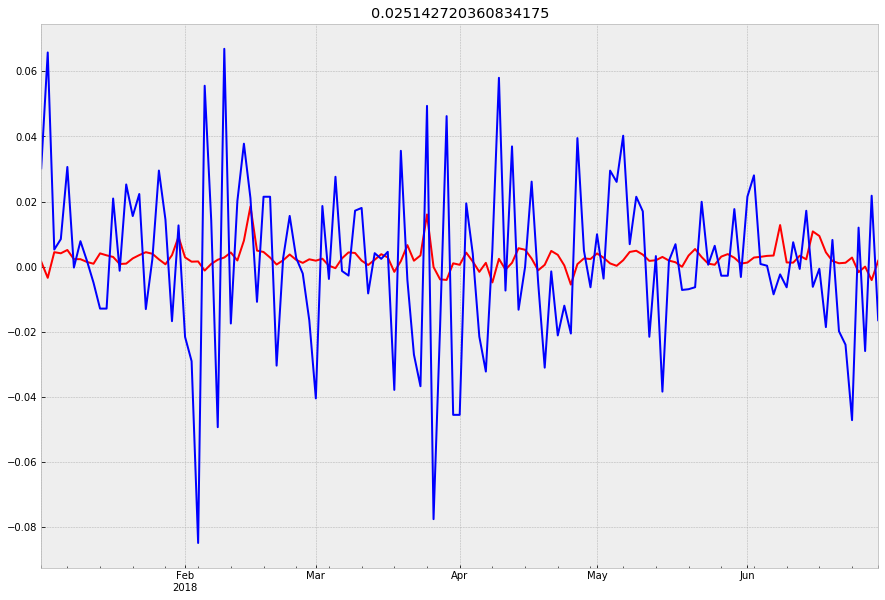

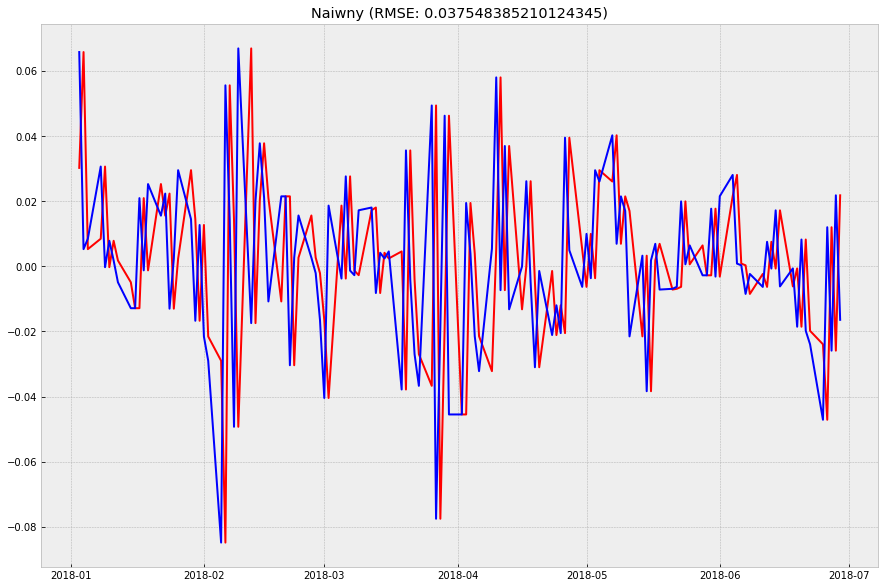

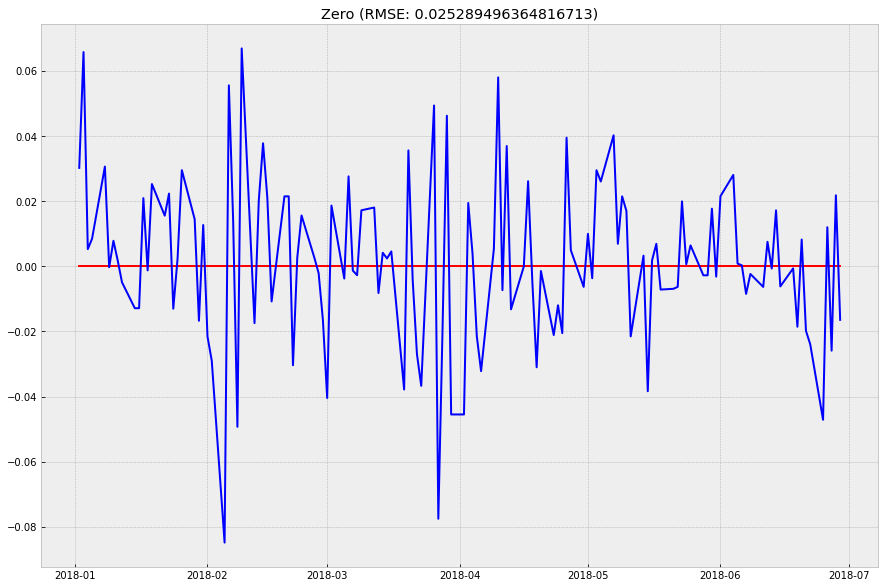

In [38]:
forecasts.plot(color='red', label='Forecast')
y_test_base.plot(color='blue', label='Real')
plt.title(rmse(y_test_base, forecasts))
plt.show()
show_est_plot(y_test_base, naiwny=True, label='Naiwny')
show_est_plot(y_test_base, zero=True, label='Zero')

## Test

In [40]:
order = (3,0,2)
variables = ['MIN_diff_1', 'MININDEX_diff_1_shift_19']
test["week"] = test.index.week
y_train_base = pd.concat([train1, val1, val2, val3]).asfreq('B', method='bfill')['y_return_ratio']
x_train_base = pd.concat([train1, val1, val2, val3]).asfreq('B', method='bfill')[variables]
y_test_base = test['y_return_ratio']
x_test_base = test[variables]

/home/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/home/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [42]:
model = SARIMAX(y_train_base, x_train_base, order=order, freq='B', trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:         y_return_ratio   No. Observations:                 1565
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3748.650
Date:                Sun, 14 Apr 2019   AIC                          -7479.299
Time:                        13:03:34   BIC                          -7431.098
Sample:                    07-02-2012   HQIC                         -7461.381
                         - 06-29-2018                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    0.0024      0.001      3.074      0.002       0.001       0.004
MIN_diff_1                   0.0010      0.000      2.884      0.004       0.000       0.

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [43]:
forecasts = []
for i in range(len(y_test_base)):
    y_train = pd.concat([y_train_base, y_test_base[:i]]).asfreq('B', method='bfill')
    x_train = pd.concat([x_train_base, x_test_base[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, x_train, order=order, freq='B', trend='c', enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit()
    forecasts.append(results.forecast(exog=x_test_base[i:i+1])[0])
forecasts = pd.Series(forecasts, index=y_test_base.index)

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood opti

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

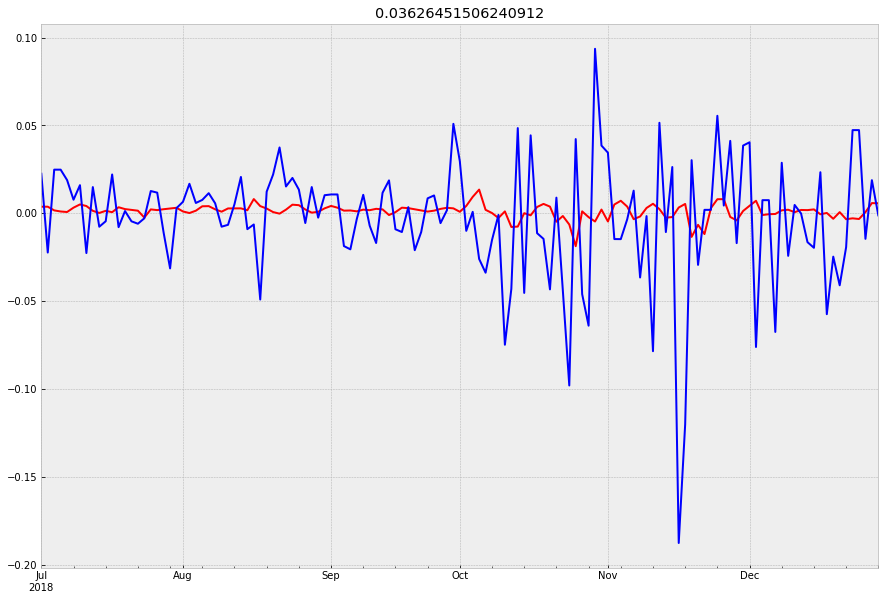

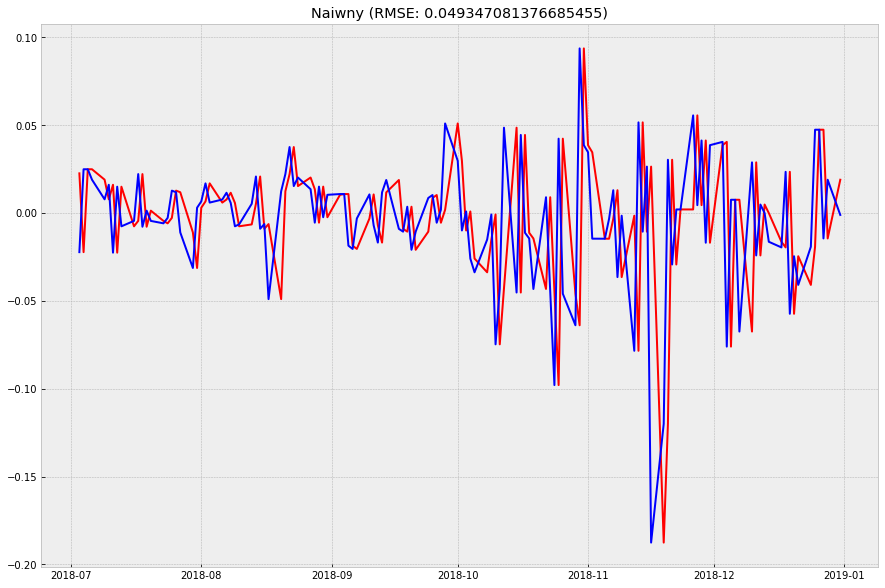

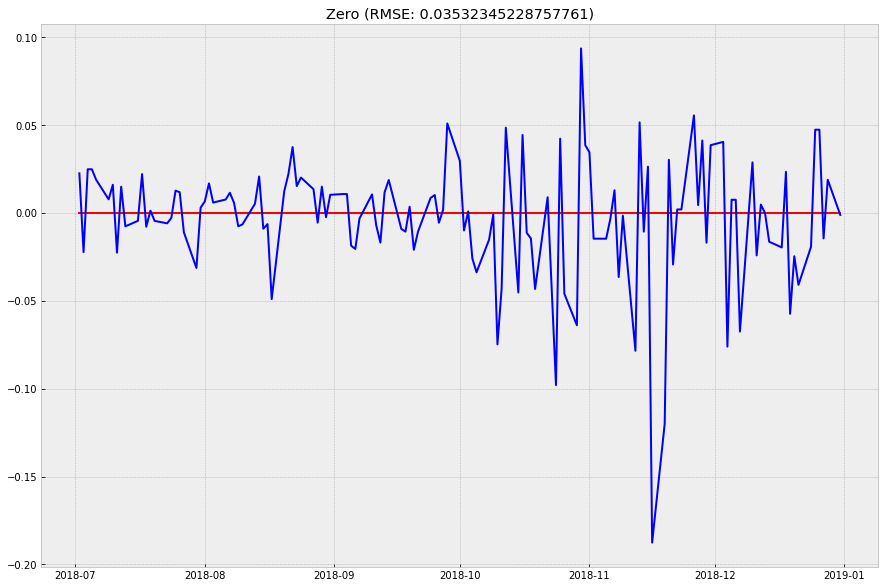

In [44]:
forecasts.plot(color='red', label='Forecast')
y_test_base.plot(color='blue', label='Real')
plt.title(rmse(y_test_base, forecasts))
plt.show()
show_est_plot(y_test_base, naiwny=True, label='Naiwny')
show_est_plot(y_test_base, zero=True, label='Zero')